#  Прогнозирование заказов такси

Собраны исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час, построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Этапы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
print(data.index.is_monotonic)
data.isna().sum()

True


num_orders    0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Ресемплирование данных по одному часу:

In [5]:
data = data.resample('1H').sum()

## Анализ

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(data)

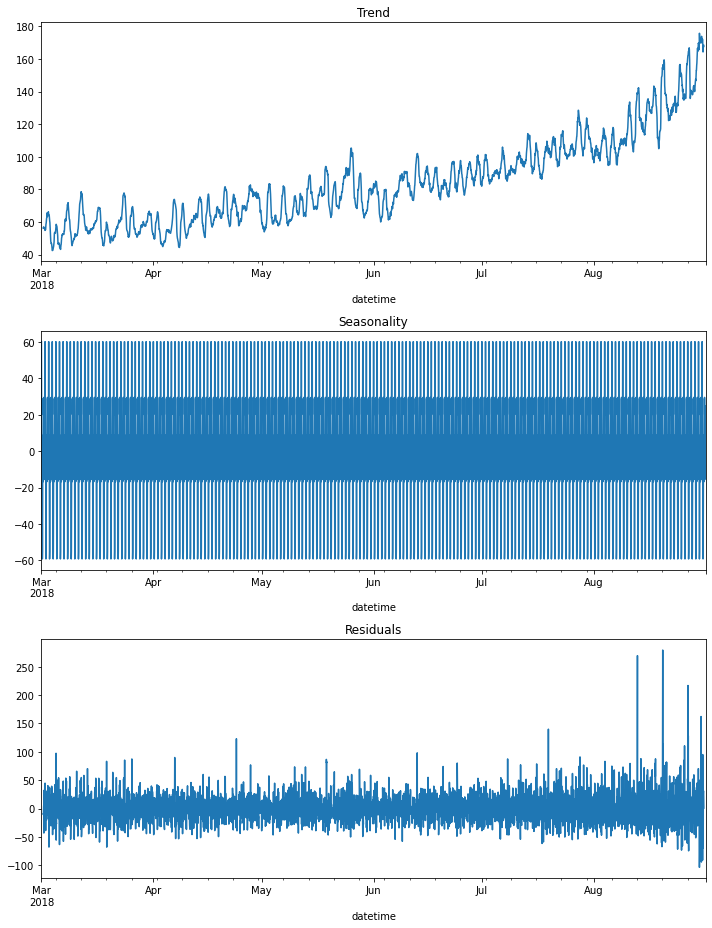

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 13))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

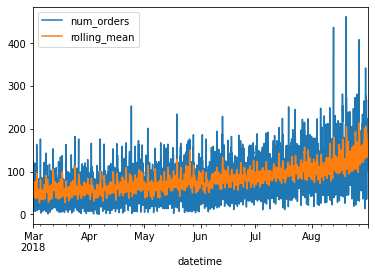

In [8]:
data['rolling_mean'] = data.rolling(10).mean()
data.plot()

Создание признаков для временных рядов:

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    for lag in range(1, max_lag + 1):
        data['dayofweek'] = data.index.dayofweek
        data['hour'] = data.index.hour
        
        for lag in range(1, max_lag + 1):
            data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

        data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [10]:
make_features(data, 1, 24)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   rolling_mean  4392 non-null   float64
 2   dayofweek     4416 non-null   int64  
 3   hour          4416 non-null   int64  
 4   lag_1         4415 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 207.0 KB


Разобьем данные на обучающую и тестовую выборки(90%:10%):

In [11]:
train, test = train_test_split(data,  test_size = 0.1, random_state = 12345, shuffle=False)
train = train.dropna()

train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']

test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

## Обучение

LINEAR REGRESSION

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
model = LinearRegression()

print(f'''Значение метрики RMSE на обучающей выборке для LinearRegression''', abs(cross_val_score(model,train_features, train_target, 
                         cv = TimeSeriesSplit(n_splits=20), 
                         n_jobs = -1, 
                         scoring = 'neg_root_mean_squared_error').mean()))

Значение метрики RMSE на обучающей выборке для LinearRegression 30.762581006695648


CATBOOST

In [13]:
parameters = {'depth': range(1, 5, 1),
              'learning_rate': np.arange(0.00, 0.15, 0.05),
              'iterations':  range(0, 10, 5)}

In [14]:
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(CatBoostRegressor(), param_grid = parameters, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
gsearch.fit(train_features, train_target)
abs(gsearch.best_score_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

0:	learn: 29.1081126	total: 46.1ms	remaining: 184ms
1:	learn: 28.8780432	total: 46.4ms	remaining: 69.5ms
2:	learn: 28.6126519	total: 46.5ms	remaining: 31ms
3:	learn: 28.4359319	total: 46.7ms	remaining: 11.7ms
4:	learn: 28.2211572	total: 46.8ms	remaining: 0us
0:	learn: 29.3035458	total: 220us	remaining: 880us
1:	learn: 29.0442427	total: 587us	remaining: 880us
2:	learn: 28.8128669	total: 794us	remaining: 529us
3:	learn: 28.5771606	total: 905us	remaining: 226us
4:	learn: 28.3617583	total: 1.1ms	remaining: 0us
0:	learn: 29.1570064	total: 331us	remaining: 1.32ms
1:	learn: 28.9379278	total: 761us	remaining: 1.14ms
2:	learn: 28.6988994	total: 1.07ms	remaining: 710us
3:	learn: 28.5003359	total: 1.29ms	remaining: 322us
4:	learn: 28.3193699	total: 1.51ms	remaining: 0us
0:	learn: 30.7368754	total: 295us	remaining: 1.18ms
1:	learn: 30.4988641	total: 749us	remaining: 1.12ms
2:	learn: 30.2908910	total: 989us	remaining: 659us
3:	learn: 30.0675127	total: 1.18ms	remaining: 293us
4:	learn: 29.8806386	to

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

0:	learn: 28.8960889	total: 349us	remaining: 1.4ms
1:	learn: 28.3554123	total: 812us	remaining: 1.22ms
2:	learn: 28.0282416	total: 1.07ms	remaining: 712us
3:	learn: 27.7638935	total: 1.42ms	remaining: 354us
4:	learn: 27.4573225	total: 1.64ms	remaining: 0us
0:	learn: 29.1170484	total: 259us	remaining: 1.04ms
1:	learn: 28.5344185	total: 648us	remaining: 972us
2:	learn: 28.0384591	total: 841us	remaining: 560us
3:	learn: 27.7365149	total: 1.02ms	remaining: 256us
4:	learn: 27.4691086	total: 1.2ms	remaining: 0us
0:	learn: 29.0796124	total: 305us	remaining: 1.22ms
1:	learn: 28.5494232	total: 709us	remaining: 1.06ms
2:	learn: 28.2518232	total: 965us	remaining: 643us
3:	learn: 27.9730526	total: 1.16ms	remaining: 290us
4:	learn: 27.7197914	total: 1.36ms	remaining: 0us
0:	learn: 30.6633472	total: 342us	remaining: 1.37ms
1:	learn: 30.3406720	total: 764us	remaining: 1.15ms
2:	learn: 29.9873779	total: 1.09ms	remaining: 727us
3:	learn: 29.7250774	total: 1.32ms	remaining: 330us
4:	learn: 29.4554072	to

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

0:	learn: 28.7655004	total: 295us	remaining: 1.18ms
1:	learn: 28.3740903	total: 691us	remaining: 1.04ms
2:	learn: 27.8314645	total: 885us	remaining: 590us
3:	learn: 27.3649357	total: 1.06ms	remaining: 265us
4:	learn: 26.9243982	total: 1.22ms	remaining: 0us
0:	learn: 28.9789110	total: 316us	remaining: 1.26ms
1:	learn: 28.4150137	total: 719us	remaining: 1.08ms
2:	learn: 27.8283237	total: 949us	remaining: 632us
3:	learn: 27.3213795	total: 1.17ms	remaining: 292us
4:	learn: 26.8187888	total: 1.41ms	remaining: 0us
0:	learn: 28.9784031	total: 366us	remaining: 1.47ms
1:	learn: 28.4013189	total: 916us	remaining: 1.37ms
2:	learn: 27.8704751	total: 1.25ms	remaining: 833us
3:	learn: 27.4143204	total: 1.57ms	remaining: 391us
4:	learn: 26.9546809	total: 1.87ms	remaining: 0us
0:	learn: 30.4888144	total: 395us	remaining: 1.58ms
1:	learn: 29.9270177	total: 927us	remaining: 1.39ms
2:	learn: 29.3799224	total: 1.27ms	remaining: 844us
3:	learn: 28.9389219	total: 1.6ms	remaining: 400us
4:	learn: 28.4726403	

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1953, in _prepare_train_params
    _check_train_params(params)
  File "_catboost.pyx", line 5839, in _catboost._check_train_params
  File "_catboost.pyx", line 5858, in _catboost._check_train

0:	learn: 28.7129814	total: 555us	remaining: 2.22ms
1:	learn: 28.1682656	total: 1.03ms	remaining: 1.55ms
2:	learn: 27.7311500	total: 1.27ms	remaining: 845us
3:	learn: 27.1127408	total: 1.62ms	remaining: 404us
4:	learn: 26.6494097	total: 1.91ms	remaining: 0us
0:	learn: 28.9391679	total: 390us	remaining: 1.56ms
1:	learn: 28.2994480	total: 846us	remaining: 1.27ms
2:	learn: 27.7463582	total: 1.22ms	remaining: 813us
3:	learn: 27.1895062	total: 1.55ms	remaining: 387us
4:	learn: 26.7296766	total: 1.95ms	remaining: 0us
0:	learn: 28.8289337	total: 468us	remaining: 1.87ms
1:	learn: 28.2114500	total: 1.05ms	remaining: 1.58ms
2:	learn: 27.7174355	total: 1.43ms	remaining: 952us
3:	learn: 27.3272049	total: 1.78ms	remaining: 444us
4:	learn: 26.8996481	total: 2.17ms	remaining: 0us
0:	learn: 30.4474604	total: 497us	remaining: 1.99ms
1:	learn: 29.8760025	total: 1.22ms	remaining: 1.83ms
2:	learn: 29.3568646	total: 1.62ms	remaining: 1.08ms
3:	learn: 28.8745436	total: 2.05ms	remaining: 511us
4:	learn: 28.4

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [         nan          nan          nan          nan -37.84551762
 -36.89465786          nan          nan          nan          nan
 -37.32700637 -35.88020321          nan          nan          nan
          nan -36.71898383 -34.92617653          nan          nan
          nan          nan -36.49451487 -34.50484433]
  warnings.warn(


0:	learn: 36.9907725	total: 843us	remaining: 3.37ms
1:	learn: 35.6392357	total: 1.72ms	remaining: 2.58ms
2:	learn: 34.5527061	total: 2.46ms	remaining: 1.64ms
3:	learn: 33.3609582	total: 3.11ms	remaining: 777us
4:	learn: 32.5367075	total: 3.78ms	remaining: 0us


34.504844330188156

СЛУЧАЙНЫЙ ЛЕС

In [15]:
from sklearn.ensemble import RandomForestRegressor
parameters = { 'n_estimators': range (1, 20, 1),
              'max_depth': range (1, 20, 1)}

In [16]:
tscv = TimeSeriesSplit(n_splits=8)
gsearch_tree = GridSearchCV(RandomForestRegressor(), param_grid = parameters, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)
gsearch_tree.fit(train_features, train_target)
abs(gsearch_tree.best_score_)

Fitting 8 folds for each of 361 candidates, totalling 2888 fits


25.025550629938113

RMSE LINEAR REGRESSION = 30.762581006695648

RMSE CATBOOST = 34.552179501252866

RMSE СЛУЧАЙНЫЙ ЛЕС = 25.241107612543793

Лучшая модель - СЛУЧАЙНЫЙ ЛЕС

## Тестирование

In [17]:
pred_test = gsearch_tree.predict(test_features)
print(mean_squared_error(pred_test, test_target)**0.5)

46.89818728402087


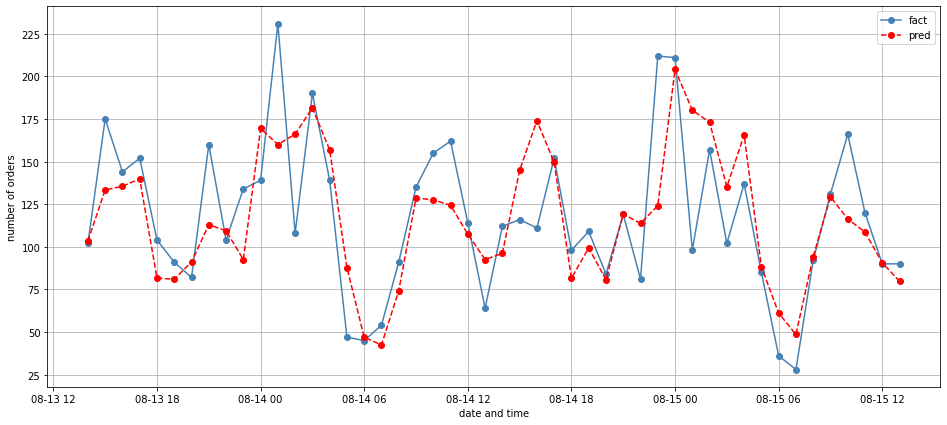

In [18]:
actual_ = test_target[0:48]
pferict_data = pd.DataFrame(pred_test[0:48], index = actual_.index)
plt.figure(figsize=(16, 7))
plt.plot(actual_, 'ro', color = 'steelblue', linestyle = '-', label = 'fact')
plt.plot(pferict_data, 'ro', color = 'r', linestyle = '--', label = 'pred')
plt.legend()
plt.xlabel('date and time')
plt.ylabel('number of orders')
plt.grid(True)
plt.show()